In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install sentence-transformers datasets transformers

In [3]:
import pandas as pd
import re


# read input document
X = pd.read_csv('/content/train_set.csv')
X = X[['feedback', 'label']]


X['feedback'] = X['feedback'].apply(lambda x: x.lower())
X['feedback'] = X['feedback'].apply((lambda x: re.sub('[^a-zA-z0-9\s]', '', x)))


df = pd.read_csv('/content/test_set.csv')
df = df[['feedback', 'label']]

df['feedback'] = df['feedback'].apply(lambda x: x.lower())
df['feedback'] = df['feedback'].apply((lambda x: re.sub('[^a-zA-z0-9\s]', '', x)))



V = pd.read_csv('/content/validation_set.csv')
V = V[['feedback', 'label']]

V['feedback'] = V['feedback'].apply(lambda x: x.lower())
V['feedback'] = V['feedback'].apply((lambda x: re.sub('[^a-zA-z0-9\s]', '', x)))



In [4]:
print("Train Set")
print(X.shape)
print(X['label'].value_counts())

print("Test Set")
print(df.shape)
print(df['label'].value_counts())

print("Validation Set")
print(V.shape)
print(V['label'].value_counts())

print("Concatenated Dataset")
dataset=pd.concat([X,df,V])
print(dataset.shape)

Train Set
(656, 2)
label
0    97
4    88
8    87
3    80
1    72
2    70
5    66
7    65
6    31
Name: count, dtype: int64
Test Set
(225, 2)
label
0    25
1    25
2    25
3    25
4    25
5    25
6    25
7    25
8    25
Name: count, dtype: int64
Validation Set
(116, 2)
label
0    17
4    16
8    16
3    14
1    13
2    12
5    12
7    11
6     5
Name: count, dtype: int64
Concatenated Dataset
(997, 2)


In [5]:

print(dataset['label'].value_counts())
print(dataset.info())
sampled_df = dataset.groupby('label').sample(n=100, random_state=1,replace=True,)

print(sampled_df['label'].value_counts())
print(sampled_df.info())


label
0    139
4    129
8    128
3    119
1    110
2    107
5    103
7    101
6     61
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 997 entries, 0 to 115
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   feedback  997 non-null    object
 1   label     997 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 23.4+ KB
None
label
0    100
1    100
2    100
3    100
4    100
5    100
6    100
7    100
8    100
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 900 entries, 37 to 115
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   feedback  900 non-null    object
 1   label     900 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 21.1+ KB
None


In [6]:
import random
from nltk.corpus import wordnet
import nltk
nltk.download('wordnet')


def synonym_replacement(sentence, n):
    words = sentence.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words if wordnet.synsets(word)]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:  # only replace up to n words
            break

    sentence = ' '.join(new_words)
    return sentence

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonyms.add(l.name())
    if word in synonyms:
        synonyms.remove(word)
    return list(synonyms)

def random_insertion(sentence, n):
    words = sentence.split()
    for _ in range(n):
        new_word = get_synonyms(random.choice(words))
        if new_word:
            words.insert(random.randint(0, len(words)), random.choice(new_word))
    return ' '.join(words)

def random_swap(sentence, n):
    words = sentence.split()
    for _ in range(n):
        idx1, idx2 = random.sample(range(len(words)), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    return ' '.join(words)

def random_deletion(sentence, p):
    words = sentence.split()
    if len(words) == 1:  # return if single word
        return sentence

    new_words = []
    for word in words:
        if random.uniform(0, 1) > p:
            new_words.append(word)
    if len(new_words) == 0:  # ensure at least one word remains
        new_words.append(random.choice(words))
    return ' '.join(new_words)

# Example usage:
sentence = "This is a sample sentence for data augmentation."

sentence = "john has not progressed in his position he is continuously late leaves early and takes many breaks throughout the day he calls out at least every other week and its always on fridays his performance has significantly declined my suggestion is he is not suitable for this position"

print("Original Sentence:", sentence)
print("Synonym Replacement:", synonym_replacement(sentence, 10))
print("Random Insertion:", random_insertion(sentence, 10))
print("Random Swap:", random_swap(sentence, 10))
print("Random Deletion:", random_deletion(sentence, 0.4))




[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Original Sentence: john has not progressed in his position he is continuously late leaves early and takes many breaks throughout the day he calls out at least every other week and its always on fridays his performance has significantly declined my suggestion is he is not suitable for this position
Synonym Replacement: john has non progressed in his position he follow continuously late leaves early and takes many happy_chance passim the solar_day he hollo out at to_the_lowest_degree every former week and its invariably on fridays his carrying_out has significantly declined my suggestion follow he follow non suitable for this position
Random Insertion: invariably john has not progressed in his comprise position expose he is continuously late along leaves early and takes many breaks spot throughout the day he calls out at least every other week and its always Hoosier_State on fridays his performance has significantly latterly declined my suggestion is he is not on suitable for this positi

In [7]:
import numpy as np
# Original data
original_sentences = list(sampled_df['feedback'].values)
original_labels = list(sampled_df['label'].values)

# Augmented data
augmented_sentences = []
for sentence in original_sentences:
    augmented_sentences.append(synonym_replacement(sentence, 10))
    augmented_sentences.append(random_insertion(sentence, 10))
    augmented_sentences.append(random_swap(sentence, 10))
    augmented_sentences.append(random_deletion(sentence, 0.3))

# Combine original and augmented data
all_sentences = original_sentences + augmented_sentences

# Repeat labels for the augmented sentences
augmented_labels = np.repeat(original_labels, 4)  # assuming each sentence generates 4 augmented versions
all_labels = np.concatenate((original_labels, augmented_labels))

print(len(all_sentences),len(all_labels))

4500 4500


In [8]:
m=0
for i in all_sentences:
  m=max(m,len(i.split()))
print("Maximum Words",m)

Maximum Words 133


In [9]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(all_sentences,all_labels,test_size=0.1,random_state=50)

In [10]:
print("Training Samples",len(x_train))
print("Testing Samples",len(x_test))

Training Samples 4050
Testing Samples 450


In [11]:
x_train[:5],y_train[:5]

(['celine is one attitude the beat employees filters have to she in comes date with a the of and that we through into her work any time we have an issue she is complete to accept positive the she improve in that particular area and stays after hours to ensure everything for criticism day is quick and we know she has a bright future ahead of her',
  'peter like laid back person this company needs all employees to put maximum effort and itt clear through his he has impressive history of experiences and talent to succeed this position must focus on projects entirely and on time',
  'celine clayton cost an right-down joyousness to work with and be around she has a can suffice attitude and everybody seems to delight her presence on round_top of this she performs At a in_high_spirits level than anyone else in the office and can out compete anyone celine has an exceedingly bright future here and will surely wax up in the ranks fast',
  'rachel harper is an a1 employee punctuality is there con

In [12]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [13]:
from datasets import Dataset
train_df = pd.DataFrame({'text': x_train, 'label': y_train})
train_dataset = Dataset.from_pandas(train_df)
test_df = pd.DataFrame({'text': x_test, 'label': y_test})
test_dataset = Dataset.from_pandas(test_df)

In [14]:
id2label = {
      0: "Risk (Low performance, Low potential)",
      1: "Average performer (Moderate performance, Low potential)",
      2: "Solid Performer (High performance, Low potential)",
      3: "Inconsistent Player (Low performance, Moderate potential)",
      4: "Core Player (Moderate performance, Moderate potential)",
      5: "High Performer (High performance, Moderate potential)",
      6: "Potential Gem (Low performance, High potential)",
      7: "High Potential (Moderate performance, High potential)",
      8: "Star (High performance, High potential)"
            }
label2id = {
      "Risk (Low performance, Low potential)":0,
      "Average performer (Moderate performance, Low potential)":1,
      "Solid Performer (High performance, Low potential)":2,
      "Inconsistent Player (Low performance, Moderate potential)":3,
      "Core Player (Moderate performance, Moderate potential)":4,
      "High Performer (High performance, Moderate potential)":5,
      "Potential Gem (Low performance, High potential)":6,
      "High Potential (Moderate performance, High potential)":7,
      "Star (High performance, High potential)":8
}

In [15]:
from transformers import TFAutoModelForSequenceClassification,AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

model = TFAutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=9, id2label=id2label, label2id=label2id
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/4050 [00:00<?, ? examples/s]

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

In [17]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [18]:
from transformers import create_optimizer
import tensorflow as tf

batch_size = 16
num_epochs = 5
batches_per_epoch = len(tokenized_train) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

In [19]:
tf_train_set = model.prepare_tf_dataset(
    tokenized_train,
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)


tf_test_set = model.prepare_tf_dataset(
    tokenized_test,
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

In [20]:
import tensorflow as tf

model.compile(optimizer=optimizer,metrics=['accuracy'])  # No loss argument!

In [21]:
history=model.fit(x=tf_train_set, validation_data=tf_test_set, epochs=10)

Epoch 1/10
253/253 [==============================] - 153s 422ms/step - loss: 1.9434 - accuracy: 0.2851 - val_loss: 1.3206 - val_accuracy: 0.6511
Epoch 2/10
253/253 [==============================] - 99s 391ms/step - loss: 0.8104 - accuracy: 0.8273 - val_loss: 0.3545 - val_accuracy: 0.9267
Epoch 3/10
253/253 [==============================] - 98s 388ms/step - loss: 0.2158 - accuracy: 0.9770 - val_loss: 0.1466 - val_accuracy: 0.9778
Epoch 4/10
253/253 [==============================] - 98s 387ms/step - loss: 0.0897 - accuracy: 0.9968 - val_loss: 0.0892 - val_accuracy: 0.9844
Epoch 5/10
253/253 [==============================] - 100s 396ms/step - loss: 0.0590 - accuracy: 1.0000 - val_loss: 0.0794 - val_accuracy: 0.9867
Epoch 6/10
253/253 [==============================] - 100s 394ms/step - loss: 0.0544 - accuracy: 0.9998 - val_loss: 0.0794 - val_accuracy: 0.9867
Epoch 7/10
253/253 [==============================] - 98s 389ms/step - loss: 0.0543 - accuracy: 0.9998 - val_loss: 0.0794 - val

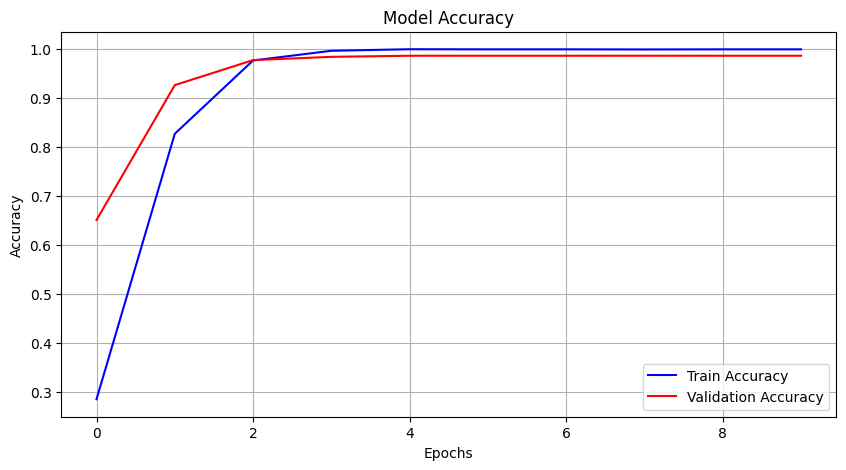

In [22]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 5))

# Plot training accuracy
plt.plot(history.history['accuracy'], color='b', label='Train Accuracy')

# Plot validation accuracy
plt.plot(history.history['val_accuracy'], color='r', label='Validation Accuracy')

# Plot customization
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='best')
plt.grid()

# Show the plot
plt.show()


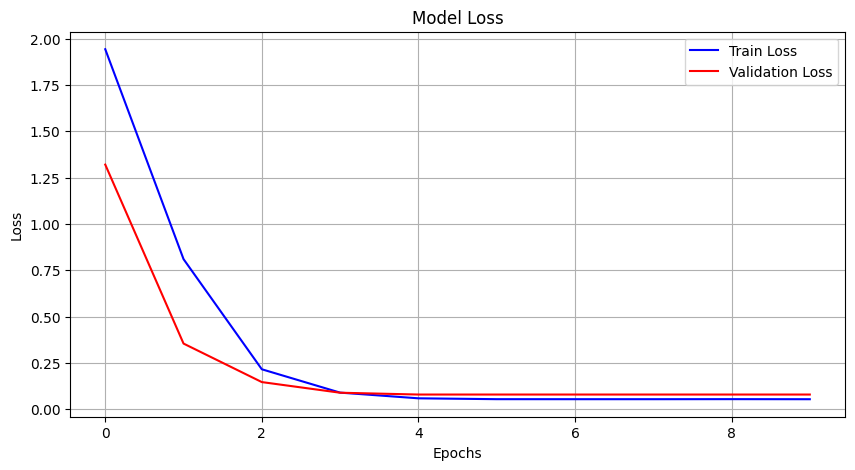

In [23]:
# Plot Loss
plt.figure(figsize=(10, 5))

# Plot training loss
plt.plot(history.history['loss'], color='b', label='Train Loss')

# Plot validation loss
plt.plot(history.history['val_loss'], color='r', label='Validation Loss')

# Plot customization
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='best')
plt.grid()

# Show the plot
plt.show()


In [24]:
save_path='/content/drive/MyDrive/EmployeeRetentionBERTBase100Samples'
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

('/content/drive/MyDrive/EmployeeRetentionBERTBase100Samples/tokenizer_config.json',
 '/content/drive/MyDrive/EmployeeRetentionBERTBase100Samples/special_tokens_map.json',
 '/content/drive/MyDrive/EmployeeRetentionBERTBase100Samples/vocab.txt',
 '/content/drive/MyDrive/EmployeeRetentionBERTBase100Samples/added_tokens.json',
 '/content/drive/MyDrive/EmployeeRetentionBERTBase100Samples/tokenizer.json')

In [25]:
import numpy as np
predictions = model.predict(tf_test_set)

logits = predictions.logits

y_pred = np.argmax(logits, axis=1)

y_true = np.array([example['label'] for example in test_dataset])


29/29 [==============================] - 7s 126ms/step


In [26]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.9866666666666667


In [27]:
from sklearn.metrics import precision_score

precision_macro = precision_score(y_true, y_pred, average='macro')
precision_micro = precision_score(y_true, y_pred, average='micro')
precision_weighted = precision_score(y_true, y_pred, average='weighted')

print(f'Macro Precision: {precision_macro:.2f}')
print(f'Micro Precision: {precision_micro:.2f}')
print(f'Weighted Precision: {precision_weighted:.2f}')

from sklearn.metrics import recall_score, f1_score

# Assuming you have y_true (true labels) and y_pred (predicted labels)
# Example placeholder data:
# y_true = ... (true labels)
# y_pred = ... (predicted labels)

# Calculate Recall for each class
recall_macro = recall_score(y_true, y_pred, average='macro')
recall_micro = recall_score(y_true, y_pred, average='micro')
recall_weighted = recall_score(y_true, y_pred, average='weighted')

print(f'Macro Recall: {recall_macro:.2f}')
print(f'Micro Recall: {recall_micro:.2f}')
print(f'Weighted Recall: {recall_weighted:.2f}')

# Calculate F1 Score for each class
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_micro = f1_score(y_true, y_pred, average='micro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print(f'Macro F1 Score: {f1_macro:.2f}')
print(f'Micro F1 Score: {f1_micro:.2f}')
print(f'Weighted F1 Score: {f1_weighted:.2f}')


Macro Precision: 0.99
Micro Precision: 0.99
Weighted Precision: 0.99
Macro Recall: 0.99
Micro Recall: 0.99
Weighted Recall: 0.99
Macro F1 Score: 0.99
Micro F1 Score: 0.99
Weighted F1 Score: 0.99


In [28]:
from sklearn.metrics import roc_auc_score
import tensorflow as tf

# Convert labels to one-hot encoding
num_classes = 9
# Convert to one-hot encoding for multi-class ROC AUC calculation
y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)
y_pred_one_hot = tf.keras.utils.to_categorical(y_pred, num_classes=num_classes)

# Compute AUC-ROC
auc_roc = roc_auc_score(y_true_one_hot, y_pred_one_hot, average='weighted', multi_class='ovr')
print(f'AUC-ROC: {auc_roc}')


AUC-ROC: 0.9924742736916861


In [29]:
from sklearn.metrics import matthews_corrcoef

# Compute MCC
mcc = matthews_corrcoef(y_true, y_pred)
print(f'Matthews Correlation Coefficient: {mcc}')


Matthews Correlation Coefficient: 0.98504244498845


In [30]:
from sklearn.metrics import log_loss
import numpy as np

# Use the logits (model outputs before softmax) or directly the probabilities from the model
predictions = model.predict(tf_test_set)

# Get logits if using a model output, apply softmax to get probabilities
logits = predictions.logits
probabilities = tf.nn.softmax(logits, axis=-1).numpy()

# Compute Log Loss
log_loss_val = log_loss(y_true, probabilities)
print(f'Log Loss: {log_loss_val}')


29/29 [==============================] - 4s 131ms/step
Log Loss: 0.07942311534368315


In [31]:
from sklearn.metrics import hamming_loss

# Compute Hamming Loss
hamming_loss_val = hamming_loss(y_true, y_pred)
print(f'Hamming Loss: {hamming_loss_val}')


Hamming Loss: 0.013333333333333334


In [32]:
from sklearn.metrics import cohen_kappa_score

# Compute Cohen's Kappa
cohen_kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa: {cohen_kappa}")


Cohen's Kappa: 0.9849821454395782


Confusion Matrix: 
[[52  0  0  0  0  0  0  0  0]
 [ 0 54  0  0  0  0  0  0  0]
 [ 0  0 47  0  0  0  0  0  0]
 [ 0  0  0 39  0  0  2  1  0]
 [ 0  0  0  0 55  0  0  0  0]
 [ 0  0  0  0  0 44  0  0  2]
 [ 0  0  0  0  0  0 55  1  0]
 [ 0  0  0  0  0  0  0 51  0]
 [ 0  0  0  0  0  0  0  0 47]]


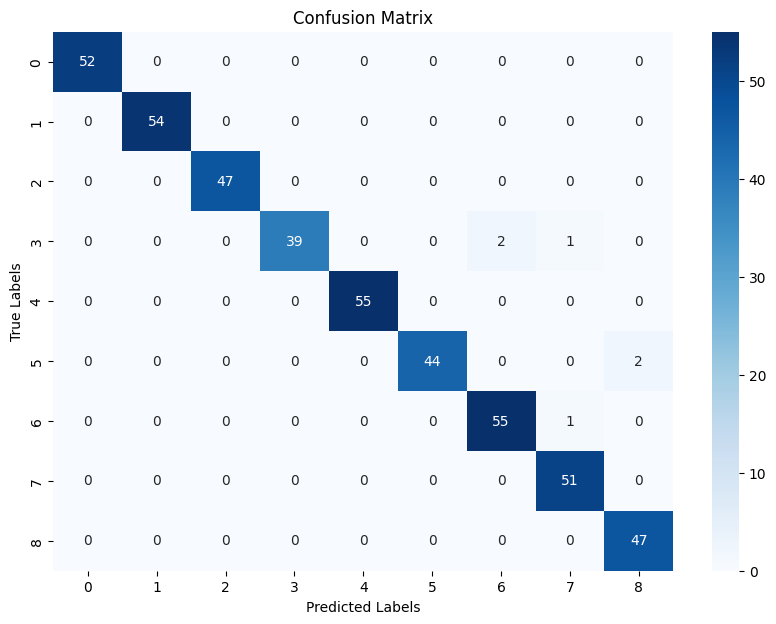

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Display Confusion Matrix
print(f'Confusion Matrix: \n{conf_matrix}')

# Plot Confusion Matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [34]:
from sklearn.metrics import classification_report

# Compute Classification Report
class_report = classification_report(y_true, y_pred)
print(f'Classification Report: \n{class_report}')


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        52
           1       1.00      1.00      1.00        54
           2       1.00      1.00      1.00        47
           3       1.00      0.93      0.96        42
           4       1.00      1.00      1.00        55
           5       1.00      0.96      0.98        46
           6       0.96      0.98      0.97        56
           7       0.96      1.00      0.98        51
           8       0.96      1.00      0.98        47

    accuracy                           0.99       450
   macro avg       0.99      0.99      0.99       450
weighted avg       0.99      0.99      0.99       450

